In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing, pipeline, metrics, grid_search, cross_validation
%matplotlib inline

# Load train and test data

In [2]:
dtype_train = { #'AnimalID': np.str_,
         'Name': np.str_,
         'DateTime': np.str_,
         'AnimalType':np.str_,
         'SexuponOutcome':np.str_,
         'AgeuponOutcome':np.str_,
         'Breed': np.str_,
         'Color':np.str_,
         'OutcomeSubtype': np.str_,
         'OutcomeType':np.str_
    
}

In [3]:
train = pd.read_csv('train.csv',dtype = dtype_train, usecols= dtype_train)
target = train['OutcomeType']
labels = train['OutcomeType']

In [4]:
train = train.drop(['OutcomeSubtype','OutcomeType'],axis =1)

In [5]:
train.head(3)

,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,Hambone,2014-02-12 18:22:00,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,Emily,2013-10-13 12:44:00,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,Pearce,2015-01-31 12:28:00,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White


In [6]:
train.describe()

,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,19038,26729,26729,26728,26711,26729,26729
unique,6374,22918,2,5,44,1380,366
top,Max,2015-08-11 00:00:00,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,136,19,15595,9779,3969,8810,2824


In [5]:
dtype_test = { 
         'Name': np.str_,
         'DateTime': np.str_,
         'AnimalType':np.str_,
         'SexuponOutcome':np.str_,
         'AgeuponOutcome':np.str_,
         'Breed': np.str_,
         'Color':np.str_,    
}
test = pd.read_csv('test.csv',dtype = dtype_test,usecols= dtype_test)

In [6]:
df_all = pd.concat((train,test), axis = 0, ignore_index= True)
df_all.shape

(38185, 7)

In [8]:
print(train.shape,test.shape)

((26729, 7), (11456, 7))


In [16]:
df_all.isnull().sum()

Name              10916
DateTime              0
AnimalType            0
SexuponOutcome        1
AgeuponOutcome       24
Breed                 0
Color                 0
dtype: int64

####model_evaluation function and feature importance plot functions#######

In [7]:
from sklearn.grid_search import GridSearchCV
from time import time

def model_evaluation(X_train, y_train, clf, param_grid, cv):
    model = GridSearchCV(estimator = clf,
                         param_grid = param_grid,
                         scoring = 'log_loss',
                         cv = cv
                         )
    #fit model
    model.fit(X_train,y_train)
    print("Best score: %0.3f" % model.best_score_)
    print("Best parameters:", model.best_params_)
    return model



In [8]:
def plot_feature_importance(feature_importances,feature_names):
    ftr_imp_df = pd.DataFrame(sorted(zip(feature_names,feature_importances)
                          , key=lambda x: x[1], reverse = False)
                   )
    y_pos = np.arange(ftr_imp_df.shape[0])

    plt.barh(y_pos, ftr_imp_df[1], align='center', alpha=0.4)
    plt.yticks(y_pos, ftr_imp_df[0])
    plt.xlabel('Feature Importance')

    plt.show()

# LabelEncoder all features and target first as a benchmark

In [9]:
cat_columns = ['Name',
 'DateTime',
 'AnimalType',
 'SexuponOutcome',
 'AgeuponOutcome',
 'Breed',
 'Color']

In [10]:
LBL = preprocessing.LabelEncoder()

for col in cat_columns:
    print ("encoding %s"  %col)
    df_all[col] = LBL.fit_transform(df_all[col])

encoding Name
encoding DateTime
encoding AnimalType


/usr/local/lib/python2.7/dist-packages/numpy/lib/arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


encoding SexuponOutcome
encoding AgeuponOutcome
encoding Breed
encoding Color


In [11]:
LBL.fit(labels)

tgt_cls = dict(zip(labels.unique()
               , LBL.transform(labels.unique())))

print ("Target encoded as : ", tgt_cls)
labels = LBL.transform(labels)

('Target encoded as : ', {'Transfer': 4, 'Adoption': 0, 'Return_to_owner': 3, 'Died': 1, 'Euthanasia': 2})


In [ ]:
#####Best score: -0.944

# feature engineering: 1) datatime

In [12]:
## Get original 'DateTime' from train+test
a = pd.concat([train['DateTime'],test['DateTime']],axis =0,ignore_index= True)
df_all['DateTime'] = a

df_all['DateTime']=pd.to_datetime(df_all['DateTime'],infer_datetime_format = True, errors = 'coerce')

In [13]:
## get 7 new features, year, month, day, quater and weekday
df_all['year'] = df_all['DateTime'].dt.year
df_all['month'] = df_all['DateTime'].dt.month
df_all['day'] = df_all['DateTime'].dt.day
df_all['quarter'] = df_all['DateTime'].dt.quarter
df_all['weekday'] = df_all['DateTime'].dt.weekday
df_all['hour'] = df_all['DateTime'].dt.hour
df_all['weekOfYear'] = df_all['DateTime'].dt.weekofyear

##Remove the old feature
df_all = df_all.drop('DateTime',axis =1)
# quarter --1: Jan-Mar; 2:Apr-June; 3:July-Sept; 4:Oct-Dec
# weekday-- 0:Mon; 1:Tue...5:Saturday,6:Sunday

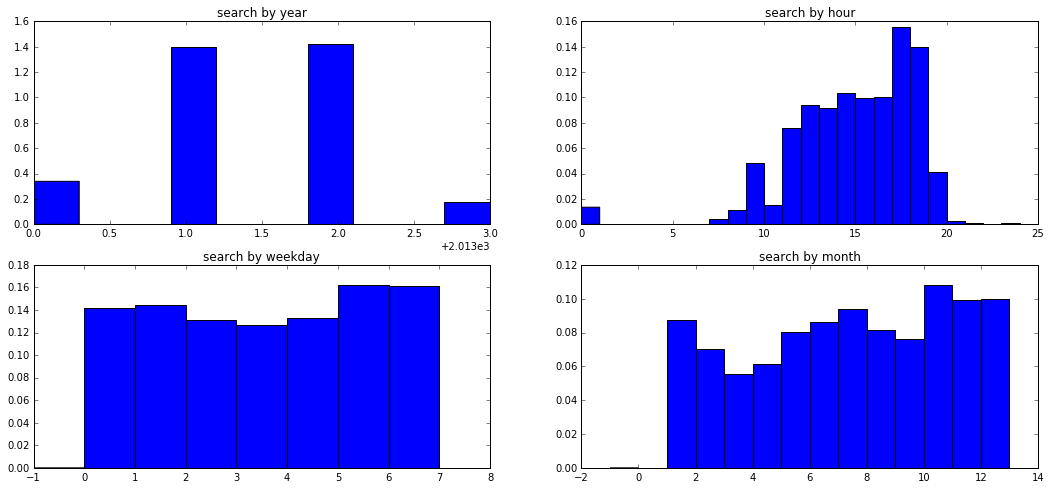

In [21]:
fig = plt.figure(figsize=(18,8))
plt.subplot(221)
plt.hist(df_all.year,bins=10,normed=True)
plt.title('search by year')

plt.subplot(222)
plt.hist(df_all.hour,range(25),normed=True)
plt.title('search by hour')

plt.subplot(223)
plt.hist(df_all.weekday,range(-1,9),normed=True)
plt.title('search by weekday')

plt.subplot(224)
plt.hist(df_all.month,range(-1,14),normed=True)
plt.title('search by month')
# weekday-- 0:Mon; 1:Tue...5:Saturday,6:Sunday

plt.show()

In [16]:
df_all.shape

(38185, 13)

###Best score: -0.813 (from -0.944--> -0.814)

#It seems that Holiday doesn't help---I can try it again
pandas- holiday or not

http://stackoverflow.com/questions/29688899/pandas-checking-if-a-date-is-a-holiday-and-assigning-boolean-value

# feature engineering: 2) AgeuponOutcome

In [26]:
#df_all.AgeuponOutcome.drop_duplicates()
# year/years, weeks, month/months, days/day, NaN

In [14]:
# year/years, weeks, month/months, days/day, NaN
def cal_age_in_years(x):
    x = str(x)
    if x =='nan': 
        return 0
    age = int(x.split()[0])
    if 'year' in x:
        return age
    if 'month' in x:
        return age/12.
    if 'day' in x:
        return age/365.
    else: 
        return 0
    
# Another way to do it:  
'''    
def calc_age_in_years(x):
    x = str(x)
    if x == 'nan': return 0
    age = int(x.split()[0])
    if x.find('year') > -1: return age 
    if x.find('month')> -1: return age / 12.
    if x.find('week')> -1: return age / 52.
    if x.find('day')> -1: return age / 365.
    else: return 0'''

"    \ndef calc_age_in_years(x):\n    x = str(x)\n    if x == 'nan': return 0\n    age = int(x.split()[0])\n    if x.find('year') > -1: return age \n    if x.find('month')> -1: return age / 12.\n    if x.find('week')> -1: return age / 52.\n    if x.find('day')> -1: return age / 365.\n    else: return 0"

In [15]:
###Get original 'AgeuponOutcome'
a = pd.concat([train['AgeuponOutcome'],test['AgeuponOutcome']],axis =0, ignore_index = True)
df_all['AgeuponOutcome'] = a

df_all['AgeuponOutcome']=df_all['AgeuponOutcome'].apply(cal_age_in_years)

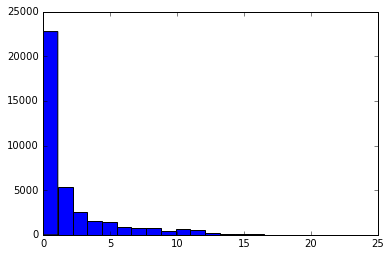

In [33]:
plt.hist(df_all.AgeuponOutcome,bins =20)
plt.show()

In [27]:
df_all.AgeuponOutcome.describe()

count    38185.000000
mean         2.157332
std          2.960130
min          0.000000
25%          0.166667
50%          1.000000
75%          3.000000
max         22.000000
Name: AgeuponOutcome, dtype: float64

In [ ]:
###Now score: -0.771 (from -0.944--> -0.813-->-0.771)--only give numbers of years ( no noise)

###  score: -0.780 ( with adding an addtitioanl binning on years)---it doesn't seem help.

In [16]:
#Add noise to Age *np.random.uniform(0.95,1.05)
mid_piv = train.shape[0]
df_all.AgeuponOutcome[:mid_piv] = df_all.AgeuponOutcome[:mid_piv]* np.random.uniform(0.95,1.05)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [18]:
from sklearn.ensemble import RandomForestClassifier
#choose a model
rf = RandomForestClassifier(n_estimators= 500, random_state= 1234, criterion='gini')
clf = rf

## Assign train_X, y_train
mid_piv = train.shape[0]
X = df_all[:mid_piv]
y = labels

#####model fitting

start = time()

param_grid = {'n_estimators':[1000]
             , 'random_state' : [1234]}

model = model_evaluation(X,y,clf,param_grid, 5)

print("this takes %.2f seconds" %(time()-start)) 

Best score: -0.771
('Best parameters:', {'n_estimators': 1000, 'random_state': 1234})
this takes 247.90 seconds


In [ ]:
###Now score: -0.771 (from -0.944--> -0.813-->-0.771)--only give numbers of years-----with some noise on training.

###  score: -0.780 ( with adding an addtitioanl binning on years)---it doesn't seem help.

### Add some noise *(0.95,1.05) to Age on training data, 
### it doesn't help on CV score of training. But it may make model more robust.

# Feature Engineering 3) SexuponOutcome

###There are two information here:
1) Sex: female or male
2) Neutered/Spayed or intact

Now try to separate these two pieces of information. And see if it can imporve the score

---No, it doesn't help

In [ ]:
###Now score: -0.774(from -0.944--> -0.814-->-0.771--> 0.774)--this helps. 
#(if we removing 'SexuponOutcome' and use new two features'sex' and 'neutered')
# This feature engineering may not help.

# Feature Engineering 4) Breed -- for this version, do not use this 

In [19]:
i = 'Breed'

a = pd.concat([train[i],test[i]],axis =0, ignore_index = True)
df_all[i] = a

('Target encoded as : ', {'Transfer': 4, 'Adoption': 0, 'Return_to_owner': 3, 'Died': 1, 'Euthanasia': 2})

In [19]:
df_all.shape

(38185, 13)

In [20]:
# target = train['OutcomeType'] this is from original data
# target has 5 different classes, so get_dummies first

target_dummy = pd.get_dummies(labels, prefix = 'OutcomeType')
target_dummy = pd.DataFrame(target_dummy, dtype=float)
target_dummy.shape

(26729, 5)

In [21]:
df_temp = pd.concat([df_all,target_dummy],axis =1)
df_temp.shape

(38185, 18)

In [22]:
df_temp.tail(2)

,Name,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,year,month,day,quarter,weekday,hour,weekOfYear,OutcomeType_0,OutcomeType_1,OutcomeType_2,OutcomeType_3,OutcomeType_4
38183,5965,1,3,6.0,German Shepherd Mix,40,2015,9,5,3,5,17,36,NaN,NaN,NaN,NaN,NaN
38184,2877,1,2,4.0,Labrador Retriever,183,2014,7,12,3,5,18,28,NaN,NaN,NaN,NaN,NaN


#To use target_mean in each level of Breed to replace breed. Since there are 5 classes, there will be 5 new features.
#Hint: for n-class you may need to derive n new features for one categorical feature instead of one for binary class.

In [22]:

i = 'Breed'
piv = train.shape[0]
temp_train = df_temp[:piv]
print ("Use group by target mean as Encoding %s" %i)

for col in target_dummy.columns:
    # get mean label, sum and size in train dataset on the basis of groupby(i) on training
    aggr = temp_train.groupby(i)[col].agg([np.size,np.sum,np.mean])
    # apply this mean to real dataset df_all
    aggr = df_temp.join(aggr, how ='left', on=i)
    
    #get new features for df_all
    df_all['Breed_mean_by_' +col] = aggr.apply(lambda row: row['mean'] ,axis =1) 
    # For those who have new level in test, give them a meanTargetAggr
    meanTagetAggr = np.mean(aggr['mean'])
    df_all['Breed_mean_by_' +col] = df_all['Breed_mean_by_' +col].fillna(meanTagetAggr)

Use group by target mean as Encoding Breed


In [23]:
df_all.isnull().sum()

Name                           0
AnimalType                     0
SexuponOutcome                 0
AgeuponOutcome                 0
Breed                          0
Color                          0
year                           0
month                          0
day                            0
quarter                        0
weekday                        0
hour                           0
weekOfYear                     0
Breed_mean_by_OutcomeType_0    0
Breed_mean_by_OutcomeType_1    0
Breed_mean_by_OutcomeType_2    0
Breed_mean_by_OutcomeType_3    0
Breed_mean_by_OutcomeType_4    0
dtype: int64

In [23]:
df_all = df_all.drop(i,axis =1)

In [22]:
df_all.shape

(38185, 17)

In [25]:
df_all.head(2)

,Name,AnimalType,SexuponOutcome,AgeuponOutcome,Color,year,month,day,quarter,weekday,hour,weekOfYear,Breed_mean_by_OutcomeType_0,Breed_mean_by_OutcomeType_1,Breed_mean_by_OutcomeType_2,Breed_mean_by_OutcomeType_3,Breed_mean_by_OutcomeType_4
0,2911,1,3,0.983195,146,2014,2,12,1,2,18,7,0.227273,0.000000,0.136364,0.454545,0.181818
1,2266,0,4,0.983195,184,2013,10,13,4,6,12,41,0.371510,0.012713,0.060726,0.039955,0.515096


In [ ]:
#Now try model fitting

In [26]:
from sklearn.ensemble import RandomForestClassifier
#choose a model
rf = RandomForestClassifier(n_estimators= 500, random_state= 1234, criterion='gini')
clf = rf

## Assign train_X, y_train
mid_piv = train.shape[0]
X = df_all[:mid_piv]
y = labels

#####model fitting

start = time()

param_grid = {'n_estimators':[1000]
             , 'random_state' : [1234]}

model = model_evaluation(X,y,clf,param_grid, 5)

print("this takes %.2f seconds" %(time()-start)) 

/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2652: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


Best score: -0.730
('Best parameters:', {'n_estimators': 1000, 'random_state': 1234})
this takes 290.02 seconds


In [ ]:
###Now score: -0.730(from -0.944--> -0.814-->-0.771-->-0.730)--this helps. 

##By using target_mean in each level of Breed to replace breed. 
##Since there are 5 classes, there will be 5 new features.

In [ ]:
###Now score: -1.337(from -0.944--> -0.814-->-0.771-->-0.730-->-1.337)--this doesn't help.  Remove this feature.

# Model fitting-tuning hyperparameters
#Random forest as a base model

In [ ]:
### tune 'max_features' -start from score -0.730 ( without changing color)

History:
#1) 'max_features' :'sqrt' (the best)
#2) with verbose =5 (picking from 5,10)) it seems verbose is not very important, so just use default number

#2) By trying previously, the larger n_estimator, the better model(score) it is. 
# Therefore, directly use n_estimator = 2500

In [20]:
from sklearn.ensemble import RandomForestClassifier
#choose a model
rf = RandomForestClassifier(n_estimators= 500, random_state= 1234, criterion='gini')
clf = rf

## Assign train_X, y_train
mid_piv = train.shape[0]
X = df_all[:mid_piv]
y = labels

#####model fitting

start = time()

param_grid = {'n_estimators':[2500]
             , 'random_state' : [1234]}

model = model_evaluation(X,y,clf,param_grid, 5)

print("this takes %.2f seconds" %(time()-start)) 

Best score: -0.766
('Best parameters:', {'n_estimators': 2500, 'random_state': 1234})
this takes 618.74 seconds


In [ ]:
###Now score: -0.719(from -0.944--> -0.814-->-0.771-->-0.730-0.719)--this breed engineered. 

###Now score: -0.766(from -0.944--> -0.814-->-0.771-->-0.766)--without breed engineered.


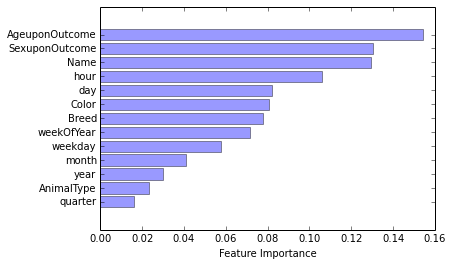

In [21]:
feature_names = df_all.columns
plot_feature_importance(model.best_estimator_.feature_importances_,feature_names)

In [19]:
### try ExtraRandomeForest
### start from score -0.774(random Forest)

## Now score: -0.747 (with n_estimators: 2500)

/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2652: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


Best score: -0.747
('Best parameters:', {'max_features': 'sqrt', 'n_estimators': 2500, 'random_state': 1234})
this takes 588.33 seconds



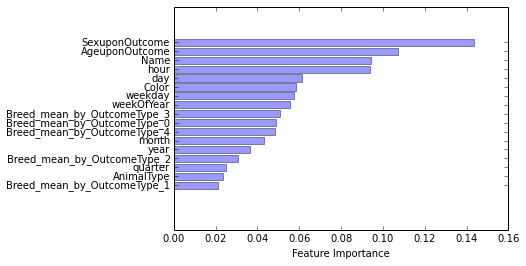

In [23]:
from sklearn.ensemble import ExtraTreesClassifier

#choose a model
extraTree = ExtraTreesClassifier(n_estimators= 2500, random_state= 1234, criterion='gini')
clf = extraTree

## Assign train_X, y_train
mid_piv = train.shape[0]
X = df_all[:mid_piv]
y = labels

#####model fitting###
start = time()

param_grid = {'n_estimators':[2500]
             , 'random_state' : [1234]
             , 'max_features': ['sqrt']}

model = model_evaluation(X,y,clf,param_grid, 5)

print("this takes %.2f seconds" %(time()-start)) 
print

###plot feature importance###
feature_names = df_all.columns
plot_feature_importance(model.best_estimator_.feature_importances_,feature_names)

# XGboost

In [17]:
#XGBoost wrapper - to enable early stopping and missing value
def xgb_train(trainX,trainY,params):
    plst = list(params.items())
    offset = int(trainX.shape[0]*0.08)
    num_rounds = 10000
    xgtrain = xgb.DMatrix(trainX[offset:,:],label = trainY[offset:],missing = -999)
    xgval = xgb.DMatrix(trainX[:offset,:],label =trainY[:offset], missing = -999)
    
    #train using early stopping and predict
    watchlist = [(xgtrain,'train'),(xgval,'val')]
    model = xgb.train(params = plst, dtrain = xgtrain, num_boost_round = num_rounds, 
                     evals = watchlist, early_stopping_rounds =100)
    print ("best score:", model.best_score)
    print ("best iteration:", model.best_iteration)
    return model

def xgb_pred(model,testX, params):
    xgtest = xgb.DMatrix(testX, missing = -999)
    preds = model.predict(xgtest, ntree_limit = model.best_iteration)
    return preds



In [18]:
def plot_xgb_importance(model):
    pd.Seriesmp = pd.Series(model.booster().get_fscore()).sort_values(ascending = False)
    y_pos = np.aranfeature_names(feat_imp.shape[0])
    
    plt.barh(y_pos,feat_imp, align='center', alpha =0.4)
    plt.yticks(y_pos, feat_imp)
    plt.xlabel('Feature Importance')
    
    plt.show()


Step 1 - choose a relatively larger learning rate(0.02) then use early stopping for optimal rounds
Initial parameters (works well for most cases)

learning rate: 0.02

max_depth: 6

min_child_weight: 1

colsample_bytree: 0.7

subsample : 0.7


In [48]:
type(labels)
a = labels.reshape(mid_piv)
print labels.shape, type(labels),a.shape, type(a)


(26729,) <type 'numpy.ndarray'> (26729,) <type 'numpy.ndarray'>


In [24]:
import xgboost as xgb
params = {    "booster":  "gbtree", 
          "objective": "multi:softprob"
          , "num_class": 6
          , "eval_metric":  "mlogloss" #metric to evaluate
          , "eta": 0.02
          , "subsample": 0.7
          , "colsample_bytree": 0.7
          , "max_depth": 6
          , "min_child_weight": 1
          , "seed" : 1234
          ,"silent" : False
         }

### Assign train_X, train_y(need to do a reshape)
mid_piv = train.shape[0]
X = df_all[:mid_piv].values
y = labels.reshape(mid_piv)


model = xgb_train(X,y,params)
##I got:
#('best score:', 0.768)
#('best iteration:', 723)

Will train until val error hasn't decreased in 100 rounds.
[0]	train-mlogloss:1.768203	val-mlogloss:1.769056
[1]	train-mlogloss:1.745755	val-mlogloss:1.746851
[2]	train-mlogloss:1.723806	val-mlogloss:1.725411
[3]	train-mlogloss:1.699998	val-mlogloss:1.702204
[4]	train-mlogloss:1.677974	val-mlogloss:1.680536
[5]	train-mlogloss:1.655979	val-mlogloss:1.659060
[6]	train-mlogloss:1.635072	val-mlogloss:1.638723
[7]	train-mlogloss:1.614811	val-mlogloss:1.618944
[8]	train-mlogloss:1.597826	val-mlogloss:1.602478
[9]	train-mlogloss:1.579302	val-mlogloss:1.584448
[10]	train-mlogloss:1.561180	val-mlogloss:1.566805
[11]	train-mlogloss:1.544754	val-mlogloss:1.550757
[12]	train-mlogloss:1.528036	val-mlogloss:1.534387
[13]	train-mlogloss:1.511409	val-mlogloss:1.518285
[14]	train-mlogloss:1.496607	val-mlogloss:1.504018
[15]	train-mlogloss:1.481478	val-mlogloss:1.489493
[16]	train-mlogloss:1.467348	val-mlogloss:1.475730
[17]	train-mlogloss:1.451982	val-mlogloss:1.460816
[18]	train-mlogloss:1.438540	val-

('best score:', 0.767702)
('best iteration:', 723)


[820]	train-mlogloss:0.558680	val-mlogloss:0.767831
[821]	train-mlogloss:0.558520	val-mlogloss:0.767828
[822]	train-mlogloss:0.558361	val-mlogloss:0.767856
[823]	train-mlogloss:0.558160	val-mlogloss:0.767812
Stopping. Best iteration:
[723]	train-mlogloss:0.577510	val-mlogloss:0.767702



In [ ]:
#('best score:', 0.767702)
#('best iteration:', 723)

In [19]:
def model_evaluation(X_train, y_train, clf, param_grid, cv):
    model = GridSearchCV(estimator = clf,
                         param_grid = param_grid,
                         scoring = 'log_loss',
                         cv = cv
                         )
    #fit model
    model.fit(X_train,y_train)
    print("Best score: %0.3f" % model.best_score_)
    print("Best parameters:", model.best_params_)
    return model

Cross validate for base line performance

In [26]:
start = time()
param_grid = {"objective": ["multi:softprob"]
              , "learning_rate": [0.02]
              , "max_depth": [6]
              , "min_child_weight": [1]
              , "n_estimators": [723]   #<best iteration (rounds) from last step 1, e.g. [697]>
              , "subsample": [0.7]
              , "colsample_bytree": [0.7]
              , "nthread": [-1]
              , "silent" : [True]
              , "seed": [1234]}

clf = xgb.XGBClassifier()
model = model_evaluation(X,y,clf,param_grid, 5)

print("this takes %.2f seconds" %(time()-start)) 

Best score: -0.747
('Best parameters:', {'colsample_bytree': 0.7, 'silent': True, 'learning_rate': 0.02, 'nthread': -1, 'min_child_weight': 1, 'n_estimators': 723, 'subsample': 0.7, 'seed': 1234, 'objective': 'multi:softprob', 'max_depth': 6})
this takes 114.86 seconds


In [ ]:
#Now score is -0.747

#('best iteration:', 723)

Step2
- tune max_depth and min_child_weight
Use learning rate 0.02 and the optimal rounds we got from step two, the do grid search for max_depth and min_child_weight



In [22]:
import xgboost as xgb

### Assign train_X, train_y(need to do a reshape)
mid_piv = train.shape[0]
X = df_all[:mid_piv].values
y = labels.reshape(mid_piv)

start = time()
param_grid = {"objective": ["multi:softprob"]
              , "learning_rate": [0.02]
              , "max_depth": [6,7,8,9]
              , "min_child_weight": [1,3,5]
              , "n_estimators": [723]   #<best iteration (rounds) from last step 1---697, e.g. [1000]>
              , "subsample": [0.7]
              , "colsample_bytree": [0.7]
              , "nthread": [-1]
              , "silent" : [False]
              , "seed": [1234]}

clf = xgb.XGBClassifier()
model = model_evaluation(X,y,clf,param_grid, 5)

print ("best max_depth:", model.best_params_['max_depth'])
print ("best min_child_weight:", model.best_params_['min_child_weight'])

print("this takes %.2f seconds" %(time()-start)) 
## ('best max_depth:', 9)
##('best min_child_weight:', 3)

/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2652: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


Best score: -0.740
('Best parameters:', {'colsample_bytree': 0.7, 'silent': False, 'learning_rate': 0.02, 'nthread': -1, 'min_child_weight': 3, 'n_estimators': 723, 'subsample': 0.7, 'seed': 1234, 'objective': 'multi:softprob', 'max_depth': 9})
('best max_depth:', 9)
('best min_child_weight:', 3)
this takes 1490.35 seconds


In [29]:
model.best_estimator_

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.02, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=723, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1234, silent=False, subsample=0.7)

In [23]:
print("Best score: %0.3f" % model.best_score_)
print ("best max_depth:", model.best_params_['max_depth'])
print ("best min_child_weight:", model.best_params_['min_child_weight'])

Best score: -0.740
('best max_depth:', 9)
('best min_child_weight:', 3)


In [ ]:
#Now score is -0.740

#('best iteration:', 723)
## ('best max_depth:', 9)
##('best min_child_weight:', 3)

Step3
- tune gamma

In [24]:
start = time()
param_grid = {"objective": ["multi:softprob"]
              , "learning_rate": [0.02]
              , "max_depth": [9]
              , "min_child_weight": [3]
              , "n_estimators": [723]   #<best iteration (rounds) from last step 1---697, e.g. [1000]>
              , "subsample": [0.7]
              , "colsample_bytree": [0.7]
              , "nthread": [-1]
              , "silent" : [False]
              , "seed": [1234]
             ,"gamma":[i/10.0 for i in range(0,5)]}

clf = xgb.XGBClassifier()
model = model_evaluation(X,y,clf,param_grid, 5)

print ("best gamma:", model.best_params_['gamma'])

print("this takes %.2f seconds" %(time()-start)) 
#('best iteration:', 723)
## ('best max_depth:', 9)
##('best min_child_weight:', 3)
## 'best gamma:', 0.3

Best score: -0.740
('Best parameters:', {'colsample_bytree': 0.7, 'silent': False, 'learning_rate': 0.02, 'nthread': -1, 'min_child_weight': 3, 'n_estimators': 723, 'subsample': 0.7, 'seed': 1234, 'objective': 'multi:softprob', 'max_depth': 9, 'gamma': 0.3})
('best gamma:', 0.3)
this takes 1369.40 seconds


In [ ]:
#Now score is -0.740

#('best iteration:', 723)
## ('best max_depth:', 9)
##('best min_child_weight:', 3)
###('best gamma': 0.3)

Step4
- tune subsample and colsample_bytree

In [25]:
start = time()
param_grid = {"objective": ["multi:softprob"]
              , "learning_rate": [0.02]
              , "max_depth": [9] #<fill in with the best max_depth from step 2, e.g. [7]>
              , "min_child_weight": [3] #<fill in with the best min_child_weight from last step, e.g. [1]>
              , "n_estimators": [723] #<fill in with best iteration (rounds) from last step, e.g. [1000]>
              , "subsample": [0.5,0.6,0.7,0.8,0.9]
              , "colsample_bytree": [0.5,0.6,0.7,0.8,0.9]
              , "nthread": [-1]
              , "silent" : [False]
              , "seed": [1234]
              ,"gamma":[0.3]}  #<fill in with the best gamma from last step, e.g. [1]>}


clf = xgb.XGBClassifier()
model = model_evaluation(X,y,clf,param_grid, 5)

print ("best subsample:", model.best_params_['subsample'])
print ("best 'colsample_bytree':", model.best_params_['colsample_bytree'])

print("this takes %.2f seconds" %(time()-start)) 
#('best iteration:', 723)
## ('best max_depth:', 9)
##('best min_child_weight:', 3)
###('best gamma':0.3)
###  ("subsample":0.9)
### ("colsample_bytree": 0.5)

Best score: -0.736
('Best parameters:', {'colsample_bytree': 0.5, 'silent': False, 'learning_rate': 0.02, 'nthread': -1, 'min_child_weight': 3, 'n_estimators': 723, 'subsample': 0.9, 'seed': 1234, 'objective': 'multi:softprob', 'max_depth': 9, 'gamma': 0.3})


KeyError: 'max_subsample'

In [27]:
print ("best subsample:", model.best_params_['subsample'])
print ("best 'colsample_bytree':", model.best_params_['colsample_bytree'])


('best subsample:', 0.9)
("best 'colsample_bytree':", 0.5)


In [ ]:
#Now score is -0.736

Step 5
- tune regularization--reg_lambda reg_lambda=1(default)

In [28]:
import xgboost as xgb

### Assign train_X, train_y(need to do a reshape)
mid_piv = train.shape[0]
X = df_all[:mid_piv].values
y = labels.reshape(mid_piv)


start = time()
param_grid = {"objective": ["multi:softprob"]
              , "learning_rate": [0.02]
              , "max_depth": [9] #<fill in with the best max_depth from step 2, e.g. [7]>
              , "min_child_weight": [3] #<fill in with the best min_child_weight from last step, e.g. [1]>
              , "n_estimators": [723] #<fill in with best iteration (rounds) from last step, e.g. [1000]>
              , "subsample": [0.9]
              , "colsample_bytree": [0.5]
              , "nthread": [-1]
              , "silent" : [False]
              , "seed": [1234]
             ,"gamma":[0.3]
             ,"reg_lambda": [1,5,10]}  #<fill in with the best gamma from last step, e.g. [1]>}

clf = xgb.XGBClassifier()
model = model_evaluation(X,y,clf,param_grid, 5)

print ("best reg_lambda:", model.best_params_['reg_lambda'])

print("this takes %.2f seconds" %(time()-start)) 
#('best iteration:', 723)
## ('best max_depth:', 9)
##('best min_child_weight:', 3)
###('best gamma':0.3)
###  ("subsample":0.9)
### ("colsample_bytree": 0.5)
## (reg_lambda": [1])

Best score: -0.736
('Best parameters:', {'colsample_bytree': 0.5, 'silent': False, 'learning_rate': 0.02, 'nthread': -1, 'min_child_weight': 3, 'n_estimators': 723, 'subsample': 0.9, 'reg_lambda': 1, 'seed': 1234, 'objective': 'multi:softprob', 'max_depth': 9, 'gamma': 0.3})
('best reg_lambda:', 1)
this takes 399.59 seconds


In [ ]:
#Now score is -0.736

In [ ]:
Step 6 - decrease learning rate for better performace

Use learning rate 0.01 tuned parameters max_depth, min_childe_weight, subsample and colsample_bytreee from step 2 and 3, repeat early stopping for better rounds


In [29]:
#('best iteration:', 723)
## ('best max_depth:', 9)
##('best min_child_weight:', 3)
###('best gamma':0.3)
###  ("subsample":0.9)
### ("colsample_bytree": 0.5)
## (reg_lambda": [1])

#Now score is -0.686
start = time()
params = {  "objective": "multi:softprob"
          , "num_class": 6
          , "booster":  "gbtree"
          , "eval_metric":  "mlogloss"
          , "eta": 0.01
          , "subsample":0.9 # <fill in with the best subsample from step 3, e.g. 0.7>
          , "colsample_bytree":0.5 #<fill in with the best colsample_bytree from step 3, e.g. 0.7>
          , "max_depth": 9 #<fill in with the best max_depth from step 2, e.g. 7>
          , "min_child_weight": 3 # <fill in with the best min_child_weight from step 2, e.g.1>
          , "seed" : 1234
          ,"reg_lambda": 1
          ,"gamma": 0.3
          ,"silent" : False
         }


### Assign train_X, train_y(need to do a reshape)
mid_piv = train.shape[0]
X = df_all[:mid_piv].values
y = labels.reshape(mid_piv)


model = xgb_train(X,y,params)

print("this takes %.2f seconds" %(time()-start)) 

##I got:
#('best score:', 0.755253)
#('best iteration:', 1433)

Will train until val error hasn't decreased in 100 rounds.
[0]	train-mlogloss:1.780182	val-mlogloss:1.780805
[1]	train-mlogloss:1.769663	val-mlogloss:1.770970
[2]	train-mlogloss:1.757622	val-mlogloss:1.759557
[3]	train-mlogloss:1.748012	val-mlogloss:1.750743
[4]	train-mlogloss:1.736239	val-mlogloss:1.739570
[5]	train-mlogloss:1.724195	val-mlogloss:1.728157
[6]	train-mlogloss:1.712661	val-mlogloss:1.717271
[7]	train-mlogloss:1.701099	val-mlogloss:1.706236
[8]	train-mlogloss:1.690542	val-mlogloss:1.696465
[9]	train-mlogloss:1.680082	val-mlogloss:1.686520
[10]	train-mlogloss:1.670052	val-mlogloss:1.677044
[11]	train-mlogloss:1.658628	val-mlogloss:1.666049
[12]	train-mlogloss:1.648516	val-mlogloss:1.656711
[13]	train-mlogloss:1.637294	val-mlogloss:1.645962
[14]	train-mlogloss:1.628884	val-mlogloss:1.638206
[15]	train-mlogloss:1.619505	val-mlogloss:1.629499
[16]	train-mlogloss:1.610439	val-mlogloss:1.621011
[17]	train-mlogloss:1.601402	val-mlogloss:1.612577
[18]	train-mlogloss:1.592731	val-

('best score:', 0.755253)
('best iteration:', 1433)
this takes 183.01 seconds


[1532]	train-mlogloss:0.398223	val-mlogloss:0.755756
[1533]	train-mlogloss:0.398104	val-mlogloss:0.755745
Stopping. Best iteration:
[1433]	train-mlogloss:0.409847	val-mlogloss:0.755253



In [30]:
start = time()
param_grid = {"objective": ["multi:softprob"]
              , "learning_rate": [0.01]
              , "max_depth": [9] #<fill in with the best max_depth from step 2, e.g. [7]>
              , "min_child_weight": [3] #<fill in with the best min_child_weight from last step, e.g. [1]>
              , "n_estimators": [1433] #<fill in with best iteration (rounds) from last step, e.g. [1000]>
              , "subsample": [0.9]
              , "colsample_bytree": [0.5]
              , "nthread": [-1]
              , "silent" : [False]
              , "seed": [1234]
             ,"gamma":[0.3]
             ,"reg_lambda": [1]}


clf = xgb.XGBClassifier()
model = model_evaluation(X,y,clf,param_grid, 5)

print("this takes %.2f seconds" %(time()-start)) 

Best score: -0.735
('Best parameters:', {'colsample_bytree': 0.5, 'silent': False, 'learning_rate': 0.01, 'nthread': -1, 'min_child_weight': 3, 'n_estimators': 1433, 'subsample': 0.9, 'reg_lambda': 1, 'seed': 1234, 'objective': 'multi:softprob', 'max_depth': 9, 'gamma': 0.3})
this takes 344.70 seconds


In [ ]:
### Best score: -0.735 

In [ ]:
def plot_xgb_importance(model):
    pd.Seriesmp = pd.Series(model.booster().get_fscore()).sort_values(ascending = False)
    y_pos = np.aranfeature_names(feat_imp.shape[0])
    
    plt.barh(y_pos,feat_imp, align='center', alpha =0.4)
    plt.yticks(y_pos, feat_imp)
    plt.xlabel('Feature Importance')
    
    plt.show()


In [32]:
plot_xgb_importance(model)

AttributeError: 'GridSearchCV' object has no attribute 'booster'

# Prediction and submission

For real prediction, we still need to fit a single model to datasets 
(cross_validation is not working)

In [31]:
prediction = model.predict_proba(df_all[mid_piv:])

In [32]:
prediction.shape

(11456, 5)

In [33]:
prediction[:5]

array([[  1.90099031e-02,   1.34600501e-03,   3.22357528e-02,
          1.23432860e-01,   8.23975503e-01],
       [  6.35988653e-01,   7.29531457e-04,   1.18003758e-02,
          3.04313987e-01,   4.71674204e-02],
       [  4.25646752e-01,   1.83501863e-03,   1.62587985e-02,
          1.98967904e-01,   3.57291520e-01],
       [  2.75321960e-01,   3.74041684e-03,   1.62992366e-02,
          8.78001973e-02,   6.16838157e-01],
       [  5.15608430e-01,   1.21553440e-03,   4.62472998e-03,
          4.10971880e-01,   6.75794408e-02]], dtype=float32)

In [34]:
submission = pd.read_csv('sample_submission.csv')
submission[['Adoption','Died','Euthanasia','Return_to_owner','Transfer']] = prediction
submission.to_csv('submit-Final1-xgb-nobreed.csv',index = False)
print ('job done. csv ready in your expedia folder.')

job done. csv ready in your expedia folder.


In [ ]:
# submit-Final1-xgb-trial1.csv: LB score: 0.71780 (without breed engineering )
### Best CV score: -0.735  (without breed engineering)
# CV score: Best score: -0.685 ( with Breed feature engineering)